# Sentiment Analysis for Hotel Reviews

## Overview
This project is analyzing sentiment in hotel reviews using **Mutual Information** and **Vader Sentiment Analyzer**.

We use **Vader sentiment analyzer, Mutual Information and Point-wise Mutual Information** to discover the relation between those metrics and ground-truth rating scores.

## What we are going to do

1. Read the data (.csv format) into **pandas dataframe**

2. Use **Vader sentiment analyzer****bag-of-words model** (unigram)

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains.

3. Calculate **word frequency**, **mutual information** and **pointwise mutual information** for the unigrams to see how they relate with the review scores

4. **Visualize** the distribution of the ground-truth scores and Vader scores
5. Discuss

### Install and import the packages

In [2]:
#Download required ntlk packages and lib
import nltk
# nltk.download("vader_lexicon")
# nltk.download("stopwords")

In [3]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from collections import Counter
import re
import sys
import math
import html
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

%matplotlib inline

### Test the Vader analyzer

In [3]:
#Sentences to try with vader
# sentences = ["VADER is smart, handsome, and funny.",
#              "Data Scientists are sexy!",
#              "The room was dirty and small",
#              "They had excellent facilities!",
#              "This hotel is the worst hotel in the city"]

In [4]:
#Instantiate an instance to access SentimentIntensityAnalyzer class
# sid = SentimentIntensityAnalyzer()

In [5]:
#Vader output
# for sentence in sentences:
#     print(sentence)
#     ss = sid.polarity_scores(sentence)
#     for k in sorted(ss):
#          print('{0}: {1}, '.format(k, ss[k]), end='')
#     print('\n')

VADER is smart, handsome, and funny.
compound: 0.8316, neg: 0.0, neu: 0.254, pos: 0.746, 

Data Scientists are sexy!
compound: 0.5707, neg: 0.0, neu: 0.448, pos: 0.552, 

The room was dirty and small
compound: -0.4404, neg: 0.367, neu: 0.633, pos: 0.0, 

They had excellent facilities!
compound: 0.6114, neg: 0.0, neu: 0.429, pos: 0.571, 

This hotel is the worst hotel in the city
compound: -0.6249, neg: 0.339, neu: 0.661, pos: 0.0, 



It can be seen from the previous examples that **Vader sentiment analyzer** does good job in identifying polarity of the sentences and give us **compound** score which is in range of [-1, 1]. As compound is close to +1.0, the sentence has positive words and mood.

## Let's read the .csv data we scrapped from Trip Advisor

In [26]:
# Read in from pandas

# hotelDf = pd.read_csv('../hotels_data.csv', sep=";")
# hotelDf.columns = ['idx', 'rev_id', 'rating', 'title', 'text', 'username', 'user_loc', 'hotel_id', 'date_stay', 'date_review']
# hotelDf['text'] = hotelDf.apply(lambda row: '' if row['text'] is None else row['text'] , axis=1)

# hotelDfassiging groundtruth to our dataset 
# the groundtruth is categorical variable ('positive', 'negative'). 
# If the rating score is 4 or 5, we say the ground truth is positive, otherwise we say it is negative.

# hotelDf['groundTruth'] = hotelDf.apply(lambda row: 'positive' if float(row['rating']) > 3 else 'negative' , axis=1)


In [27]:
# hotelDf.head()

,idx,rev_id,rating,title,text,username,user_loc,hotel_id,date_stay,date_review,groundTruth
0,0,147643103.0,5.0,"“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,Papa_Panda,Gold Coast,93338,December 2012,"December 17, 2012",positive
1,1,147639004.0,5.0,“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...",Maureen V,"Sydney, New South Wales, Australia",93338,December 2012,"December 17, 2012",positive
2,2,147697954.0,4.0,“Great Stay”,This is a great property in Midtown. We two di...,vuguru,Houston,1762573,December 2012,"December 18, 2012",positive
3,3,147625723.0,4.0,“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,Hotel-Designer,"Laguna Beach, CA",1762573,August 2012,"December 17, 2012",positive
4,4,147612823.0,4.0,“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,JamesE339,"Saint Louis, Missouri",1762573,December 2012,"December 17, 2012",positive


In [28]:
# Instantiate the sentiment Analyzer
# sid = SentimentIntensityAnalyzer()

In [32]:

# vaderScores = []
# #Assign Vader score to individual review using Vader compound score
# for rownum, review in enumerate(hotelDf['text']):
    
#     if review is None:
#         review=""
#     if isinstance(review, str) == False:
#         review = ""
#     scores = sid.polarity_scores(review)

#     vaderScores.append(scores['compound'])
# #     if (rownum % 5000 == 0):
# #             print("processed %d reviews" % (rownum+1))
# print("completed")

completed


In [33]:
# Assign vader scores in the original df
# hotelDf = hotelDf.assign(vaderScore = vaderScores)
# hotelDf.head()

,idx,rev_id,rating,title,text,username,user_loc,hotel_id,date_stay,date_review,groundTruth,vaderScore
0,0,147643103.0,5.0,"“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,Papa_Panda,Gold Coast,93338,December 2012,"December 17, 2012",positive,0.9966
1,1,147639004.0,5.0,“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...",Maureen V,"Sydney, New South Wales, Australia",93338,December 2012,"December 17, 2012",positive,0.9783
2,2,147697954.0,4.0,“Great Stay”,This is a great property in Midtown. We two di...,vuguru,Houston,1762573,December 2012,"December 18, 2012",positive,0.9726
3,3,147625723.0,4.0,“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,Hotel-Designer,"Laguna Beach, CA",1762573,August 2012,"December 17, 2012",positive,0.9570
4,4,147612823.0,4.0,“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,JamesE339,"Saint Louis, Missouri",1762573,December 2012,"December 17, 2012",positive,0.9919


In [35]:
# hotelDf.to_csv('hotels_with_vader.csv', sep=';')

In [7]:
# hotelDf.head(5)

NameError: name 'hotelDf' is not defined

## Can we learn something about the true ratings from Vader scores?
In other words, can we build infer true review ratings by using vader score? and why even would we be intereted in that?

Usually, we have many other options for the regression problem. *Linear Regression*, *Decision Tree* and etc.

But using Vader analyzer is **simple and fast**. We can use it as an initial tool before building a heavy machine learning model to figure out the trend in the data.

#### Top 5 reviews hotel by *ratings*

In [4]:
hotelDf = pd.read_csv('hotels_with_vader.csv', sep=';')

In [5]:
ratingByHotel = hotelDf.groupby(['hotel_id']).mean()['rating'].reset_index()
vaderByHotel = hotelDf.groupby(['hotel_id']).mean()['vaderScore'].reset_index()

In [6]:
ratingByHotel = ratingByHotel.sort_values('rating', ascending=False)
ratingByHotel.head(20)

,hotel_id,rating
3985,;99766,5.0
2088,268217,5.0
1236,1643250,5.0
1316,1858908,5.0
1325,1872507,5.0
1333,1889985,5.0
1395,2160816,5.0
1606,223685,5.0
354,109075,5.0
1855,239848,5.0


#### Top 5 reviews hotel by *vader score*

In [7]:
vaderByHotel = vaderByHotel.sort_values('vaderScore', ascending=False)
vaderByHotel.head(20)

,hotel_id,vaderScore
2269,3405788,0.99760
2119,273366,0.99620
3964,;308189,0.99270
853,1206970,0.99230
3006,815515,0.99120
1130,1474749,0.98955
2596,662519,0.98920
2103,271481,0.98910
2527,631351,0.98480
1037,124066,0.98430


### The two lists are very similar!
Vader scores are highly correlated with the true rating scores.

## Which words were most sentiment-bearing in the reviews?
#### To explore this question, we will calculate the following 3 factors.
1. Word Frequency
2. Mutual Information
3. Pointwise Mutual Information (PMI)

### 1. Word Frequency
Can word frequency in review data tell us how the customers felt about the hotels?


Let's get the most frequently observed words from the *positive reviews* and *negative reviews*, respectively, to see the difference, if any.

In [15]:
hotelDf['text'] = hotelDf.apply(lambda row: '' if pd.isna(row['text']) is True else row['text'] , axis=1)
hotelDf.head()

,Unnamed: 0,idx,rev_id,rating,title,text,username,user_loc,hotel_id,date_stay,date_review,groundTruth,vaderScore
0,0,0,147643103.0,5.0,"“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,Papa_Panda,Gold Coast,93338,December 2012,"December 17, 2012",positive,0.9966
1,1,1,147639004.0,5.0,“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...",Maureen V,"Sydney, New South Wales, Australia",93338,December 2012,"December 17, 2012",positive,0.9783
2,2,2,147697954.0,4.0,“Great Stay”,This is a great property in Midtown. We two di...,vuguru,Houston,1762573,December 2012,"December 18, 2012",positive,0.9726
3,3,3,147625723.0,4.0,“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,Hotel-Designer,"Laguna Beach, CA",1762573,August 2012,"December 17, 2012",positive,0.9570
4,4,4,147612823.0,4.0,“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,JamesE339,"Saint Louis, Missouri",1762573,December 2012,"December 17, 2012",positive,0.9919


In [10]:
def get_topk_ngram(df, ngram_range=(1,1), k=None, stopwords=True, with_count=False):
    '''
    k is for max features value
    Extract the most frequently occurred words in countvector
    the ngram range of (1,1) is unigram
    (1,2) meana unigram and bigram
    (2,2) means only bigrams 
    
    max_features parameter in count vectorizer int or None, default=None
    If not None, build a vocabulary that only consider the top max_features (((((ordered by term frequency across the corpus.)))))

    This parameter is ignored if vocabulary is not None.
    '''

    my_stop_words = ENGLISH_STOP_WORDS
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=my_stop_words, max_features=k)
        
#     def conv_string(x):
#         if isinstance(x, str) == False:
#             return ''
#         else:
#             return x
        
#     df['text'] = df['text'].apply(lambda x : conv_string(x))
        
    countvector = vectorizer.fit_transform(df['text'])

    # Get topk occurred ngrams
    topk_words = []
    sortedindices = countvector.toarray().sum(axis=0).argsort()[::-1][:k]
    counts = countvector.toarray().sum(axis=0)
    print('processing...')
    for i in sortedindices:
        word = vectorizer.get_feature_names()[i]
        
        if with_count:
            count = counts[i]
            topk_words.append((word, count))
        else:
            topk_words.append(word)
            
    return topk_words

#### Top 10 Words with High Frequency in *Positive* and *Negative* reviews.

In [18]:
# topkTotal = get_topk_ngram(hotelDf, k=100)
# print('complete topTotal')
# topkTotal_bigram = get_topk_ngram(hotelDf, ngram_range=(2,2), k=100)
# print('complete topToal)
# topkPos = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='positive'], ngram_range=(1,1), k=200, with_count=True)
# print('first finished')
# topkNeg = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='negative'], ngram_range=(1,1), k=200, with_count=True)
# print('second finished')
# topkPos_bigram = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='positive'], ngram_range=(2,2), k=200, with_count=True)
# print('third finished')
# topkNeg_bigram = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='negative'], ngram_range=(2,2), k=200, with_count=True)

# print("The most frequently occured top 10 words in positive reviews")
# top_pos = pd.DataFrame(topkPos, columns=['Word', 'Count'])
# top_pos.to_csv('top_pos.csv', sep = '\t')
# print("\nThe most frequently occured top 10 words in negative reviews")
# top_neg = pd.DataFrame(topkNeg, columns=['Word', 'Count'])
# top_neg.to_csv('top_neg.csv', sep = '\t')
# print("\nThe most frequently occured top 10 bigrams in positive reviews")
# top_pos_bi = pd.DataFrame(topkPos_bigram, columns=['Word', 'Count'])
# top_pos_bi.to_csv('top_pos_bi.csv', sep = '\t')
# print("\nThe most frequently occured top 10 bigrams in negative reviews")
# top_neg_bi = pd.DataFrame(topkNeg_bigram, columns=['Word', 'Count'])
# top_neg_bi.to_csv('top_neg_bi.csv', sep = '\t')

processing...

The most frequently occured top 10 bigrams in negative reviews


### Uh.. almost same?
It seems like the term frequency doesn't tell us anything about the text. We can observe that there is no difference between the top-k word list for both positive reviews and negative reviews.

If we think about it, this result seems obvious. If a customer was really satistied with the staff in the hotel, they would mention the word, 'staff', in their review. Even if a customer didn't like the staff working in the hotel, they also would mention the word, 'staff', in their review (with some bad words).

### 2. Mutual Information

**Mutual information tells you how much you learn about X from knowing the value of Y (on average over the choice of Y).** 


Since we found the word frequency is not a good indicator for the sentiment analysis, we will examine *mutual information*  for an alternative metric.

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mutual_info_score.html

In [19]:
# positive = 1 / negative = 0
gtScore = []
for i in range(len(hotelDf)):
    if hotelDf['groundTruth'][i] == 'positive':
        gtScore.append(1)
    else:
        gtScore.append(0)

In [20]:
# max feature was 500 i had to ake it 100 because of RAM issues

In [21]:
# let's calculate Mutual Information for unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', max_features=100)
countvector = vectorizer.fit_transform(hotelDf['text'])
densevector = np.array(countvector.todense())
    
# miScore_unigram = pd.DataFrame(data = {'word': vectorizer.get_feature_names(),
#              'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]})

miScore_unigram = pd.DataFrame(data =
                               {'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(100)]}
                              , index = vectorizer.get_feature_names())



In [22]:
# Bigram version
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=100)
countvector = vectorizer.fit_transform(hotelDf['text'])
densevector = np.array(countvector.todense())
miScore_bigram = pd.DataFrame(data =
                    {'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(100)]},
                    index = vectorizer.get_feature_names())
miScore_bigram.sort_values('MI Score', inplace = True, ascending = False)
miScore_bigram.to_csv('miScorebi.csv', sep = '\t')

MemoryError: 

In [ ]:
miScore_unigram.sort_values('MI Score', inplace=True, ascending=False)
print('Mutual Information - Unigram')
miScore_unigram.head(10)

In [ ]:
miScore_bigram.sort_values('MI Score', inplace=True, ascending=False)
print('Mutual Information - Bigram')
miScore_bigram.head(10)

### What does it mean?
If we observe words having high Mutual Information scores in a review, we would learn a lot about the sentiment of review, (positive or negative).

###  3. Pointwise Mutual Information

Similar to MI, PMI is measuring for single event where MI is the average of all possible event.

The events P(x,y) = P(0,1) means the event of the review is negative but the specific word is existing in that review

#### Let's see how Pointwise Mutual Information calculated. The PMI of a pair of outcomes x and y belonging to discrete random variables X and Y quantifies the discrepancy between the probability of their coincidence given their joint distribution and their individual distributions, assuming independence.
#### To study more about Pointwise Mutual Information, see [Wikipedia](https://en.wikipedia.org/wiki/Pointwise_mutual_information) 

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/ff54cfce726857db855d4dd0a9dee2c6a5e7be99)

In [25]:
def getPMI_ngram(df, gt, uni_bi, ngram_range=(1,1), max_features=500):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english', max_features=max_features)
    countvector = vectorizer.fit_transform(hotelDf['text'])
    densevector = np.array(countvector.todense())
    
    px = sum(df['groundTruth'] == gt) / len(df)
    pmis = []
    
    for i in range(max_features):
        py = sum(densevector[:,i] == 1) / len(df)
        pxy = len(df[(df['groundTruth'] == gt) & (densevector[:,i] == 1)]) / len(df)
        
        if pxy == 0:
            pmi = math.log10((pxy + 0.0001) / (px * py))
        else:
            pmi = math.log10(pxy / (px * py))
            
        pmis.append(pmi)
        
    pmis = pd.DataFrame(data = {'pmi' + gt: pmis}, index = vectorizer.get_feature_names())
    pmis.to_csv(gt+'_'+uni_bi, sep = ';')
    return pmis.sort_values('pmi' + gt, ascending=False)

From the table above, we can see the word, 'dirty', has negatively correlated with 'positive' label because the pmi value for 'positive' label is the smallest value (-0.69) among the four values.

In [26]:
pmiPos_unigram = getPMI_ngram(hotelDf, 'positive', 'unigrams')

MemoryError: 

In [ ]:
pmiNeg_unigram = getPMI_ngram(hotelDf, 'negative', 'unigrams')

In [ ]:
pmiPos_bigram = getPMI_ngram(hotelDf, 'positive', 'bigrams', ngram_range=(2,2))

In [ ]:
pmiNeg_bigram = getPMI_ngram(hotelDf, 'negative', 'bigrams', ngram_range=(2,2))

### Let's see what PMI values tell us about the reviews

In [23]:
print('PMI for positive reviews - Unigram')
pmiPos_unigram.head(10)

PMI for positive reviews - Unigram


,pmipositive
highly,0.144365
delicious,0.128718
excellent,0.123130
thanks,0.122366
courteous,0.121178
awesome,0.121066
efficient,0.119493
fantastic,0.118174
hampton,0.117840
relaxing,0.116927


In [24]:
print('PMI for positive reviews - Bigram')
pmiPos_bigram.head(10)

PMI for positive reviews - Bigram


,pmipositive
definitely return,0.166145
highly recommended,0.166145
best hotel,0.166145
definitely stay,0.162684
definitely recommend,0.160071
highly recommend,0.155763
stayed super,0.152781
excellent service,0.152357
clean great,0.151422
stay super,0.150905


In [25]:
print('PMI for negative reviews - Unigram')
pmiNeg_unigram.head(10)

PMI for negative reviews - Unigram


,pminegative
dirty,0.420243
poor,0.412481
rude,0.398191
terrible,0.387419
smoke,0.384685
sheets,0.379035
carpet,0.377151
non,0.363026
finally,0.360436
hair,0.358227


In [26]:
print('PMI for negative reviews - Bigram')
pmiNeg_bigram.head(10)

PMI for negative reviews - Bigram


,pminegative
desk told,0.482485
told room,0.481334
desk said,0.439733
needless say,0.418544
did work,0.412714
room cleaned,0.412295
smoking room,0.408784
didn work,0.408114
non smoking,0.402457
called desk,0.397830


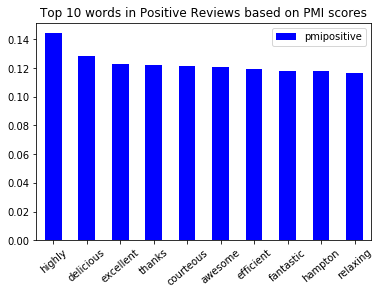

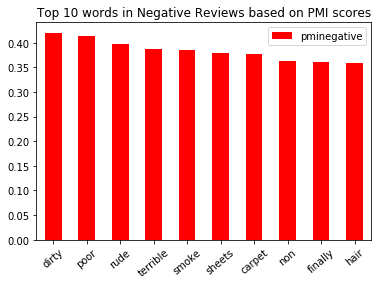

In [27]:
pmiPos_unigram.head(10).plot.bar(rot=40, color='b',
                                 title='Top 10 words in Positive Reviews based on PMI scores')
pmiNeg_unigram.head(10).plot.bar(rot=40, color='r',
                                 title='Top 10 words in Negative Reviews based on PMI scores')
plt.show()

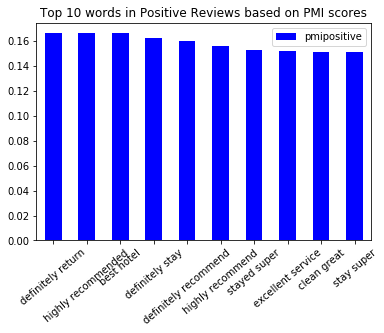

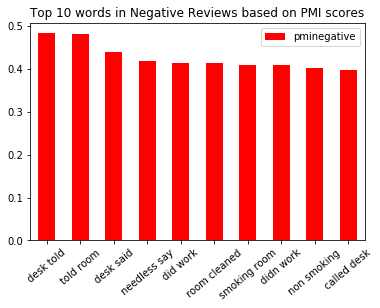

In [28]:
pmiPos_bigram.head(10).plot.bar(rot=40, color='b',
                                 title='Top 10 words in Positive Reviews based on PMI scores')
pmiNeg_bigram.head(10).plot.bar(rot=40, color='r',
                                 title='Top 10 words in Negative Reviews based on PMI scores')
plt.show()

### Pointwise Mutual Information seems like a good metric to summarize the reviews in n-gram tokens!
### By reading the n-gram tokens with high PMI scores for target variable, we can get a sense how much the reviewer did or didn't like the hotels. 

# Visualization
Sometimes, we can learn a lot about the data by visualizing.

## Historgrams

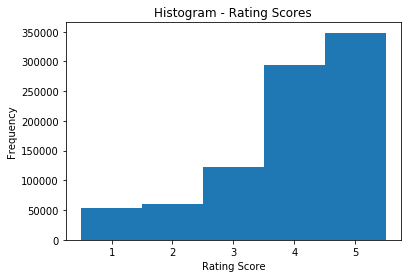

In [4]:
plt.xlabel('Rating Score')
hotelDf['overall_rating'].plot(kind='hist', title='Histogram - Rating Scores',
                            bins=np.arange(1,7)-0.5)
plt.show()

In [ ]:
plt.xlabel('Vader Sentiment Score')
hotelDf['vaderScore'].plot(kind='hist', title='Histogram - Vader Scores', 
                           xticks=[-1.0, -0.5, 0.0, 0.5, 1.0])
plt.show()

In [ ]:
#Overlayed Histogram for GT rating and VD score
#Just for demonstrating, I am dividing the rating score by 5
x = [hotelDf['overall_rating'].as_matrix() / 5]
y = [(hotelDf['vaderScore'].as_matrix() + 1 )/ 2]
bins = np.linspace(0, 1, 100)
plt.hist(x, bins, label='Rescaled True Ratings')
plt.hist(y, bins, label='Rescaled Vader Scores')
plt.title('Histogram - Rescaled')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.show()

## Boxplots

In [34]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = ratingByHotel.sort_values('overall_rating', ascending=False).head(5).hotel_id.as_matrix()

tempdf = hotelDf[(hotelDf.hotel_id == tp5gthotel[0]) | (hotelDf.hotel_id == tp5gthotel[1]) | 
         (hotelDf.hotel_id == tp5gthotel[2]) | (hotelDf.hotel_id == tp5gthotel[3]) | 
         (hotelDf.hotel_id == tp5gthotel[4])]

In [ ]:
g = sns.factorplot(kind='box',        # Boxplot
               y='ratingScore',       # Y-axis - values for boxplot
               x='hotelID',        # X-axis - first factor
               data=tempdf,        # Dataframe 
               size=6,            # Figure size (x100px)      
               aspect=1.5,        # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot

for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticklabels(labels, rotation=30) # set new labels
    
plt.show()

In [ ]:
g = sns.factorplot(kind='box',        # Boxplot
               y='vaderScore',       # Y-axis - values for boxplot
               x='hotelID',        # X-axis - first factor
               data=tempdf,        # Dataframe 
               size=6,            # Figure size (x100px)      
               aspect=1.5,        # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot

for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticklabels(labels, rotation=30) # set new labels
    
plt.show()

## Scatterplots

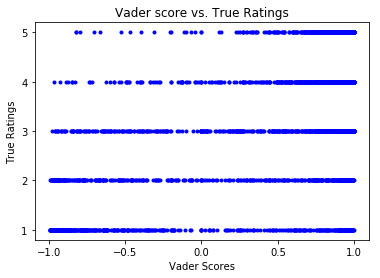

In [37]:
y = hotelDf['overall_rating'].as_matrix()
x = hotelDf['vaderScore'].as_matrix()
plt.title('Vader score vs. True Ratings')
plt.xlabel('Vader Scores')
plt.ylabel('True Ratings')
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([1,2,3,4,5])
plt.plot(x, y, "o", ms=3, color='b')
plt.show()